# 2nd Course, Part 1: Classifying digit

In this notebook we have a look at `tf.keras`, the high-level API of TensorFlow for building and training neural networks.

In [12]:
import tensorflow as tf
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('svg')


## Step 1: Loading the MNIST dataset as a `tf.data.Dataset`

We use the MNIST dataset of images of hand-written digits:

In [13]:
import tensorflow_datasets as tdfs

tdfs.disable_progress_bar()

mnist_train = tdfs.load(name='mnist', split='train')
mnist_test = tdfs.load(name='mnist', split='test')

mnist_train, mnist_test

(<DatasetV1Adapter shapes: {image: (28, 28, 1), label: ()}, types: {image: tf.uint8, label: tf.int64}>,
 <DatasetV1Adapter shapes: {image: (28, 28, 1), label: ()}, types: {image: tf.uint8, label: tf.int64}>)

Let us have a look at the first three images:

Label: 4


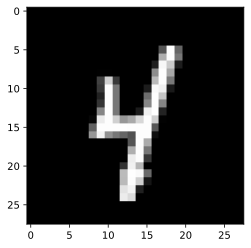

In [14]:
GRAY_CMAP = plt.get_cmap('gray')

for sample in mnist_train.take(1):  # Only take a single example
    image, label = sample["image"], sample["label"]
    print(f'Label: {label}')
    plt.imshow(image[:, :, 0], cmap=GRAY_CMAP)
    plt.show()


## Step 2: Preprocessing for classification


Our first aim is to classify the digits using a neural network. We therefore

display: unable to open X server `:1' @ error/display.c/DisplayImageCommand/407.
display: unable to open X server `:1' @ error/display.c/DisplayImageCommand/407.
- scale the image tensor so that the greyscale values are between 0 and 1, and
- one-hot-encode the labels:


In [15]:
eye = tf.eye(10, dtype='float32') # identity matrix of size 10x10


def scale_ohe(sample):
    scaled_image = tf.cast(sample['image'], 'float32') / tf.constant(255, 'float32')
    ohe_label = eye[tf.cast(sample['label'], 'int32')]
    return scaled_image,  ohe_label

Xy_train = mnist_train.map(scale_ohe)
Xy_test = mnist_test.map(scale_ohe)

print([(image.shape, label) for image, label  in Xy_train.take(4)])

[(TensorShape([28, 28, 1]), <tf.Tensor: id=396, shape=(10,), dtype=float32, numpy=array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.], dtype=float32)>), (TensorShape([28, 28, 1]), <tf.Tensor: id=398, shape=(10,), dtype=float32, numpy=array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>), (TensorShape([28, 28, 1]), <tf.Tensor: id=400, shape=(10,), dtype=float32, numpy=array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>), (TensorShape([28, 28, 1]), <tf.Tensor: id=402, shape=(10,), dtype=float32, numpy=array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], dtype=float32)>)]


To make the task more interesting, we'll add some noise to the digits:

In [16]:
NOISE_STDDEV = 0.6
noise = tf.data.Dataset.range(1).repeat().map(lambda _: tf.random.normal((28,28,1), 0.5, NOISE_STDDEV))


In [218]:
def add_noise(image, label):
    return image + tf.random.normal(image.shape, 0, NOISE_STDDEV), label

Xy_noisy_train = Xy_train.map(add_noise, 3) # don't leave out 3 here!
Xy_noisy_test = Xy_test.map(add_noise, 3) # don't leave out 3 here!


Let's check what the images look like now:

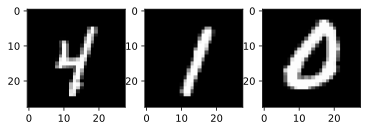

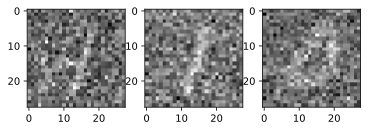

In [219]:
def show_images(dataset, nr_samples=3):
    _, axes = plt.subplots(1, nr_samples)
    for i, sample in enumerate(dataset.take(nr_samples)):
        axes[i].imshow(sample[0][:,:,0], cmap=GRAY_CMAP)
    plt.show()

show_images(Xy_train)
show_images(Xy_noisy_train)

## Step 3:  Building and training a sequential model

Let us build and train a neural network to classify the digits.

First, we build it as a sequential model, that is, as a stack of layers:

In [220]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28,28,1)),
    tf.keras.layers.Dense(10, activation='softmax'),
])
model.summary()


Model: "sequential_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_50 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_93 (Dense)             (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


Next, we specify how the model should learn, that is,

- which loss function should be optimized and
- which optimizer should be used.

Additionally, we declare a metrics that should be watched during training.

In [221]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) 

Finally, we train the model, and obtain a training history that we plot:

Epoch 1/5


      1/Unknown - 0s 205ms/step - loss: 2.3469 - accuracy: 0.0625

      2/Unknown - 0s 104ms/step - loss: 2.3450 - accuracy: 0.0938

      3/Unknown - 0s 71ms/step - loss: 2.3522 - accuracy: 0.0938 

      4/Unknown - 0s 53ms/step - loss: 2.3320 - accuracy: 0.0859

      5/Unknown - 0s 43ms/step - loss: 2.3204 - accuracy: 0.1063

      6/Unknown - 0s 36ms/step - loss: 2.3105 - accuracy: 0.0938

      7/Unknown - 0s 31ms/step - loss: 2.2896 - accuracy: 0.1205

      8/Unknown - 0s 28ms/step - loss: 2.2711 - accuracy: 0.1445

      9/Unknown - 0s 25ms/step - loss: 2.2479 - accuracy: 0.1528

     10/Unknown - 0s 22ms/step - loss: 2.2344 - accuracy: 0.1594

     11/Unknown - 0s 20ms/step - loss: 2.2191 - accuracy: 0.1676

     12/Unknown - 0s 19ms/step - loss: 2.2064 - accuracy: 0.1901

     13/Unknown - 0s 18ms/step - loss: 2.1892 - accuracy: 0.2043

     14/Unknown - 0s 16ms/step - loss: 2.1775 - accuracy: 0.2165

     15/Unknown - 0s 15ms/step - loss: 2.1655 - accuracy: 0.2250

     16/Unknown - 0s 15ms/step - loss: 2.1543 - accuracy: 0.2363

     17/Unknown - 0s 14ms/step - loss: 2.1392 - accuracy: 0.2482

     18/Unknown - 0s 13ms/step - loss: 2.1233 - accuracy: 0.2604

     19/Unknown - 0s 13ms/step - loss: 2.1127 - accuracy: 0.2747

     20/Unknown - 0s 12ms/step - loss: 2.1038 - accuracy: 0.2797

     21/Unknown - 0s 12ms/step - loss: 2.0908 - accuracy: 0.2917

     22/Unknown - 0s 11ms/step - loss: 2.0747 - accuracy: 0.3082

     23/Unknown - 0s 11ms/step - loss: 2.0614 - accuracy: 0.3179

     24/Unknown - 0s 10ms/step - loss: 2.0484 - accuracy: 0.3268

     25/Unknown - 0s 10ms/step - loss: 2.0327 - accuracy: 0.3350

     26/Unknown - 0s 10ms/step - loss: 2.0188 - accuracy: 0.3450

     27/Unknown - 0s 9ms/step - loss: 2.0060 - accuracy: 0.3519 

     28/Unknown - 0s 9ms/step - loss: 1.9957 - accuracy: 0.3560

     29/Unknown - 0s 9ms/step - loss: 1.9830 - accuracy: 0.3653

     30/Unknown - 0s 9ms/step - loss: 1.9679 - accuracy: 0.3760

     31/Unknown - 0s 8ms/step - loss: 1.9579 - accuracy: 0.3831

     32/Unknown - 0s 8ms/step - loss: 1.9495 - accuracy: 0.3877

     33/Unknown - 0s 8ms/step - loss: 1.9361 - accuracy: 0.3977

     34/Unknown - 0s 8ms/step - loss: 1.9247 - accuracy: 0.4072

     35/Unknown - 0s 8ms/step - loss: 1.9119 - accuracy: 0.4170

     36/Unknown - 0s 7ms/step - loss: 1.8986 - accuracy: 0.4253

     37/Unknown - 0s 7ms/step - loss: 1.8856 - accuracy: 0.4324

     38/Unknown - 0s 7ms/step - loss: 1.8769 - accuracy: 0.4375

     39/Unknown - 0s 7ms/step - loss: 1.8633 - accuracy: 0.4463

     40/Unknown - 0s 7ms/step - loss: 1.8542 - accuracy: 0.4539

     41/Unknown - 0s 7ms/step - loss: 1.8420 - accuracy: 0.4642

     42/Unknown - 0s 7ms/step - loss: 1.8295 - accuracy: 0.4717

     43/Unknown - 0s 7ms/step - loss: 1.8178 - accuracy: 0.4782

     44/Unknown - 0s 6ms/step - loss: 1.8067 - accuracy: 0.4837

     45/Unknown - 0s 6ms/step - loss: 1.7948 - accuracy: 0.4889

     46/Unknown - 0s 6ms/step - loss: 1.7842 - accuracy: 0.4932

     47/Unknown - 0s 6ms/step - loss: 1.7746 - accuracy: 0.4993

     48/Unknown - 0s 6ms/step - loss: 1.7630 - accuracy: 0.5046

     49/Unknown - 0s 6ms/step - loss: 1.7578 - accuracy: 0.5064

     50/Unknown - 0s 6ms/step - loss: 1.7505 - accuracy: 0.5100

     51/Unknown - 0s 6ms/step - loss: 1.7377 - accuracy: 0.5159

     52/Unknown - 0s 6ms/step - loss: 1.7286 - accuracy: 0.5198

     53/Unknown - 0s 6ms/step - loss: 1.7179 - accuracy: 0.5248

     54/Unknown - 0s 6ms/step - loss: 1.7081 - accuracy: 0.5289

     55/Unknown - 0s 5ms/step - loss: 1.7024 - accuracy: 0.5307

     56/Unknown - 0s 5ms/step - loss: 1.6960 - accuracy: 0.5335

     57/Unknown - 0s 5ms/step - loss: 1.6896 - accuracy: 0.5367

     58/Unknown - 0s 5ms/step - loss: 1.6847 - accuracy: 0.5399

     59/Unknown - 0s 5ms/step - loss: 1.6764 - accuracy: 0.5434

     60/Unknown - 0s 5ms/step - loss: 1.6686 - accuracy: 0.5464

     61/Unknown - 0s 5ms/step - loss: 1.6607 - accuracy: 0.5512

     62/Unknown - 0s 5ms/step - loss: 1.6511 - accuracy: 0.5554

     63/Unknown - 0s 5ms/step - loss: 1.6456 - accuracy: 0.5565

     64/Unknown - 0s 5ms/step - loss: 1.6374 - accuracy: 0.5596

     65/Unknown - 0s 5ms/step - loss: 1.6267 - accuracy: 0.5644

     66/Unknown - 0s 5ms/step - loss: 1.6202 - accuracy: 0.5677

     67/Unknown - 0s 5ms/step - loss: 1.6099 - accuracy: 0.5728

     68/Unknown - 0s 5ms/step - loss: 1.6019 - accuracy: 0.5758

     69/Unknown - 0s 5ms/step - loss: 1.5910 - accuracy: 0.5797

     70/Unknown - 0s 5ms/step - loss: 1.5847 - accuracy: 0.5817

     71/Unknown - 0s 5ms/step - loss: 1.5796 - accuracy: 0.5836

     72/Unknown - 0s 5ms/step - loss: 1.5722 - accuracy: 0.5868

     73/Unknown - 0s 5ms/step - loss: 1.5678 - accuracy: 0.5865

     74/Unknown - 0s 5ms/step - loss: 1.5625 - accuracy: 0.5887

     75/Unknown - 0s 5ms/step - loss: 1.5554 - accuracy: 0.5913

     76/Unknown - 0s 4ms/step - loss: 1.5501 - accuracy: 0.5938

     77/Unknown - 0s 4ms/step - loss: 1.5432 - accuracy: 0.5966

     78/Unknown - 0s 4ms/step - loss: 1.5362 - accuracy: 0.5982

     79/Unknown - 0s 4ms/step - loss: 1.5286 - accuracy: 0.6001

     80/Unknown - 0s 4ms/step - loss: 1.5254 - accuracy: 0.5988

     81/Unknown - 0s 4ms/step - loss: 1.5205 - accuracy: 0.5999

     82/Unknown - 0s 4ms/step - loss: 1.5130 - accuracy: 0.6025

     83/Unknown - 0s 4ms/step - loss: 1.5090 - accuracy: 0.6043

     84/Unknown - 0s 4ms/step - loss: 1.5030 - accuracy: 0.6071

     85/Unknown - 0s 4ms/step - loss: 1.4966 - accuracy: 0.6088

     86/Unknown - 0s 4ms/step - loss: 1.4909 - accuracy: 0.6105

     87/Unknown - 0s 4ms/step - loss: 1.4852 - accuracy: 0.6121

     88/Unknown - 0s 4ms/step - loss: 1.4803 - accuracy: 0.6140

     89/Unknown - 0s 4ms/step - loss: 1.4734 - accuracy: 0.6166

     90/Unknown - 0s 4ms/step - loss: 1.4675 - accuracy: 0.6187

     91/Unknown - 0s 4ms/step - loss: 1.4616 - accuracy: 0.6209

     92/Unknown - 0s 4ms/step - loss: 1.4569 - accuracy: 0.6219

     93/Unknown - 0s 4ms/step - loss: 1.4545 - accuracy: 0.6213

     94/Unknown - 0s 4ms/step - loss: 1.4488 - accuracy: 0.6240

     95/Unknown - 0s 4ms/step - loss: 1.4422 - accuracy: 0.6260

     96/Unknown - 0s 4ms/step - loss: 1.4378 - accuracy: 0.6279

     97/Unknown - 0s 4ms/step - loss: 1.4340 - accuracy: 0.6298

     98/Unknown - 0s 4ms/step - loss: 1.4287 - accuracy: 0.6317

     99/Unknown - 0s 4ms/step - loss: 1.4260 - accuracy: 0.6316

    100/Unknown - 0s 4ms/step - loss: 1.4220 - accuracy: 0.6334

    101/Unknown - 0s 4ms/step - loss: 1.4179 - accuracy: 0.6349

    102/Unknown - 0s 4ms/step - loss: 1.4134 - accuracy: 0.6351

    103/Unknown - 0s 4ms/step - loss: 1.4066 - accuracy: 0.6380

    104/Unknown - 0s 4ms/step - loss: 1.4039 - accuracy: 0.6388

    105/Unknown - 0s 4ms/step - loss: 1.4005 - accuracy: 0.6396

    106/Unknown - 0s 4ms/step - loss: 1.3963 - accuracy: 0.6409

    107/Unknown - 0s 4ms/step - loss: 1.3930 - accuracy: 0.6425

    108/Unknown - 0s 4ms/step - loss: 1.3874 - accuracy: 0.6447

    109/Unknown - 0s 4ms/step - loss: 1.3814 - accuracy: 0.6476

    110/Unknown - 0s 4ms/step - loss: 1.3763 - accuracy: 0.6497

    111/Unknown - 0s 4ms/step - loss: 1.3731 - accuracy: 0.6515

    112/Unknown - 0s 4ms/step - loss: 1.3682 - accuracy: 0.6529

    113/Unknown - 0s 4ms/step - loss: 1.3641 - accuracy: 0.6543

    114/Unknown - 0s 4ms/step - loss: 1.3589 - accuracy: 0.6560

    115/Unknown - 0s 4ms/step - loss: 1.3549 - accuracy: 0.6579

    116/Unknown - 0s 4ms/step - loss: 1.3503 - accuracy: 0.6592

    117/Unknown - 0s 4ms/step - loss: 1.3448 - accuracy: 0.6608

    118/Unknown - 0s 3ms/step - loss: 1.3418 - accuracy: 0.6618

    119/Unknown - 0s 3ms/step - loss: 1.3378 - accuracy: 0.6626

    120/Unknown - 0s 3ms/step - loss: 1.3327 - accuracy: 0.6638

    121/Unknown - 0s 3ms/step - loss: 1.3286 - accuracy: 0.6653

    122/Unknown - 0s 3ms/step - loss: 1.3240 - accuracy: 0.6662

    123/Unknown - 0s 3ms/step - loss: 1.3206 - accuracy: 0.6672

    124/Unknown - 0s 3ms/step - loss: 1.3170 - accuracy: 0.6686

    125/Unknown - 0s 3ms/step - loss: 1.3125 - accuracy: 0.6700

    126/Unknown - 0s 3ms/step - loss: 1.3084 - accuracy: 0.6714

    127/Unknown - 0s 3ms/step - loss: 1.3041 - accuracy: 0.6727

    128/Unknown - 0s 3ms/step - loss: 1.2998 - accuracy: 0.6746

    129/Unknown - 0s 3ms/step - loss: 1.2964 - accuracy: 0.6761

    130/Unknown - 0s 3ms/step - loss: 1.2946 - accuracy: 0.6757

    131/Unknown - 0s 3ms/step - loss: 1.2898 - accuracy: 0.6775

    132/Unknown - 0s 3ms/step - loss: 1.2853 - accuracy: 0.6787

    133/Unknown - 0s 3ms/step - loss: 1.2828 - accuracy: 0.6790

    134/Unknown - 0s 3ms/step - loss: 1.2793 - accuracy: 0.6798

    135/Unknown - 0s 3ms/step - loss: 1.2749 - accuracy: 0.6812

    136/Unknown - 0s 3ms/step - loss: 1.2715 - accuracy: 0.6818

    137/Unknown - 0s 3ms/step - loss: 1.2673 - accuracy: 0.6836

    138/Unknown - 0s 3ms/step - loss: 1.2629 - accuracy: 0.6850

    139/Unknown - 0s 3ms/step - loss: 1.2597 - accuracy: 0.6857

    140/Unknown - 0s 3ms/step - loss: 1.2563 - accuracy: 0.6866

    141/Unknown - 0s 3ms/step - loss: 1.2523 - accuracy: 0.6886

    142/Unknown - 0s 3ms/step - loss: 1.2488 - accuracy: 0.6890

    143/Unknown - 0s 3ms/step - loss: 1.2457 - accuracy: 0.6906

    144/Unknown - 0s 3ms/step - loss: 1.2419 - accuracy: 0.6918

    145/Unknown - 0s 3ms/step - loss: 1.2372 - accuracy: 0.6935

    146/Unknown - 0s 3ms/step - loss: 1.2343 - accuracy: 0.6948

    147/Unknown - 0s 3ms/step - loss: 1.2326 - accuracy: 0.6952

    148/Unknown - 0s 3ms/step - loss: 1.2300 - accuracy: 0.6957

    149/Unknown - 0s 3ms/step - loss: 1.2264 - accuracy: 0.6963

    150/Unknown - 0s 3ms/step - loss: 1.2232 - accuracy: 0.6973

    151/Unknown - 0s 3ms/step - loss: 1.2209 - accuracy: 0.6972

    152/Unknown - 0s 3ms/step - loss: 1.2199 - accuracy: 0.6970

    153/Unknown - 0s 3ms/step - loss: 1.2161 - accuracy: 0.6985

    154/Unknown - 0s 3ms/step - loss: 1.2143 - accuracy: 0.6987

    155/Unknown - 0s 3ms/step - loss: 1.2114 - accuracy: 0.7000

    156/Unknown - 0s 3ms/step - loss: 1.2083 - accuracy: 0.7007

    157/Unknown - 0s 3ms/step - loss: 1.2071 - accuracy: 0.7006

    158/Unknown - 0s 3ms/step - loss: 1.2034 - accuracy: 0.7019

    159/Unknown - 0s 3ms/step - loss: 1.2010 - accuracy: 0.7024

    160/Unknown - 0s 3ms/step - loss: 1.1987 - accuracy: 0.7029

    161/Unknown - 0s 3ms/step - loss: 1.1969 - accuracy: 0.7032

    162/Unknown - 0s 3ms/step - loss: 1.1950 - accuracy: 0.7037

    163/Unknown - 0s 3ms/step - loss: 1.1926 - accuracy: 0.7044

    164/Unknown - 0s 3ms/step - loss: 1.1889 - accuracy: 0.7052

    165/Unknown - 0s 3ms/step - loss: 1.1861 - accuracy: 0.7061

    166/Unknown - 0s 3ms/step - loss: 1.1836 - accuracy: 0.7069

    167/Unknown - 0s 3ms/step - loss: 1.1793 - accuracy: 0.7081

    168/Unknown - 0s 3ms/step - loss: 1.1763 - accuracy: 0.7091

    169/Unknown - 0s 3ms/step - loss: 1.1731 - accuracy: 0.7099

    170/Unknown - 0s 3ms/step - loss: 1.1703 - accuracy: 0.7108

    171/Unknown - 1s 3ms/step - loss: 1.1676 - accuracy: 0.7114

    172/Unknown - 1s 3ms/step - loss: 1.1645 - accuracy: 0.7126

    173/Unknown - 1s 3ms/step - loss: 1.1618 - accuracy: 0.7128

    174/Unknown - 1s 3ms/step - loss: 1.1587 - accuracy: 0.7137

    175/Unknown - 1s 3ms/step - loss: 1.1564 - accuracy: 0.7143

    176/Unknown - 1s 3ms/step - loss: 1.1546 - accuracy: 0.7147

    177/Unknown - 1s 3ms/step - loss: 1.1513 - accuracy: 0.7161

    178/Unknown - 1s 3ms/step - loss: 1.1486 - accuracy: 0.7163

    179/Unknown - 1s 3ms/step - loss: 1.1451 - accuracy: 0.7168

    180/Unknown - 1s 3ms/step - loss: 1.1423 - accuracy: 0.7181

    181/Unknown - 1s 3ms/step - loss: 1.1388 - accuracy: 0.7189

    182/Unknown - 1s 3ms/step - loss: 1.1361 - accuracy: 0.7198

    183/Unknown - 1s 3ms/step - loss: 1.1330 - accuracy: 0.7205

    184/Unknown - 1s 3ms/step - loss: 1.1305 - accuracy: 0.7213

    185/Unknown - 1s 3ms/step - loss: 1.1279 - accuracy: 0.7221

    186/Unknown - 1s 3ms/step - loss: 1.1259 - accuracy: 0.7230

    187/Unknown - 1s 3ms/step - loss: 1.1235 - accuracy: 0.7236

    188/Unknown - 1s 3ms/step - loss: 1.1215 - accuracy: 0.7242

    189/Unknown - 1s 3ms/step - loss: 1.1185 - accuracy: 0.7252

    190/Unknown - 1s 3ms/step - loss: 1.1167 - accuracy: 0.7255

    191/Unknown - 1s 3ms/step - loss: 1.1148 - accuracy: 0.7261

    192/Unknown - 1s 3ms/step - loss: 1.1125 - accuracy: 0.7267

    193/Unknown - 1s 3ms/step - loss: 1.1096 - accuracy: 0.7277

    194/Unknown - 1s 3ms/step - loss: 1.1079 - accuracy: 0.7284

    195/Unknown - 1s 3ms/step - loss: 1.1049 - accuracy: 0.7290

    196/Unknown - 1s 3ms/step - loss: 1.1028 - accuracy: 0.7298

    197/Unknown - 1s 3ms/step - loss: 1.1006 - accuracy: 0.7306

    198/Unknown - 1s 3ms/step - loss: 1.0980 - accuracy: 0.7311

    199/Unknown - 1s 3ms/step - loss: 1.0970 - accuracy: 0.7310

    200/Unknown - 1s 3ms/step - loss: 1.0947 - accuracy: 0.7311

200/200 [==============================] - 1s 4ms/step - loss: 1.0947 - accuracy: 0.7311 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00


Epoch 2/5
  1/100 [..............................] - ETA: 5s - loss: 0.5360 - accuracy: 0.8750

 45/100 [============>.................] - ETA: 0s - loss: 0.5732 - accuracy: 0.8687

 91/100 [==========================>...] - ETA: 0s - loss: 0.5652 - accuracy: 0.8626

200/200 [==============================] - 0s 2ms/step - loss: 0.5566 - accuracy: 0.8656 - val_loss: 0.4753 - val_accuracy: 0.8850


Epoch 3/5
  1/100 [..............................] - ETA: 5s - loss: 0.3429 - accuracy: 0.9375

 44/100 [============>.................] - ETA: 0s - loss: 0.4130 - accuracy: 0.9027

 89/100 [=========================>....] - ETA: 0s - loss: 0.4290 - accuracy: 0.8926

200/200 [==============================] - 0s 2ms/step - loss: 0.4353 - accuracy: 0.8898 - val_loss: 0.4154 - val_accuracy: 0.8963


Epoch 4/5
  1/100 [..............................] - ETA: 5s - loss: 0.2650 - accuracy: 0.9375

 48/100 [=============>................] - ETA: 0s - loss: 0.3455 - accuracy: 0.9173

 92/100 [==========================>...] - ETA: 0s - loss: 0.3664 - accuracy: 0.9056

200/200 [==============================] - 0s 2ms/step - loss: 0.3781 - accuracy: 0.9006 - val_loss: 0.3840 - val_accuracy: 0.8997


Epoch 5/5
  1/100 [..............................] - ETA: 5s - loss: 0.2229 - accuracy: 0.9688

 47/100 [=============>................] - ETA: 0s - loss: 0.3077 - accuracy: 0.9242

 94/100 [===========================>..] - ETA: 0s - loss: 0.3334 - accuracy: 0.9119

200/200 [==============================] - 0s 2ms/step - loss: 0.3429 - accuracy: 0.9077 - val_loss: 0.3649 - val_accuracy: 0.9041


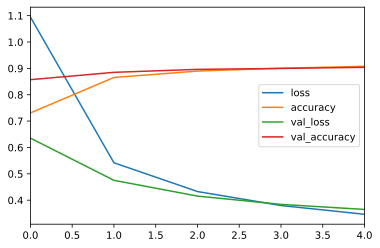

In [222]:
history = model.fit(Xy_train.batch(32).take(200), validation_data=Xy_test.batch(32).take(100), epochs=5)

def plot_history(history):
    pd.DataFrame(history.history).plot.line()

plot_history(history)

Unsurprisingly, the results are quite good already.

Before we turn to the noisy data and play around with the model, we write a short function to compile and train a given model:

In [223]:
def train(model, train_data=Xy_train, test_data=Xy_test, nr_batches=200, nr_epochs=5):
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) 
    history = model.fit(train_data.batch(32).take(nr_batches),
                        validation_data=test_data.batch(32).take(100),
                        epochs=nr_epochs)

In [224]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28,28,1)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(10, activation='softmax'),
])
train(model, Xy_noisy_train, Xy_noisy_test)

Epoch 1/5


      1/Unknown - 0s 257ms/step - loss: 2.5463 - accuracy: 0.1875

      2/Unknown - 0s 130ms/step - loss: 2.5174 - accuracy: 0.1875

      3/Unknown - 0s 88ms/step - loss: 2.5463 - accuracy: 0.1771 

      4/Unknown - 0s 66ms/step - loss: 2.5151 - accuracy: 0.1641

      5/Unknown - 0s 54ms/step - loss: 2.5463 - accuracy: 0.1562

      6/Unknown - 0s 45ms/step - loss: 2.5189 - accuracy: 0.1615

      7/Unknown - 0s 39ms/step - loss: 2.4978 - accuracy: 0.1786

      8/Unknown - 0s 34ms/step - loss: 2.4892 - accuracy: 0.1758

      9/Unknown - 0s 31ms/step - loss: 2.4637 - accuracy: 0.1736

     10/Unknown - 0s 28ms/step - loss: 2.4298 - accuracy: 0.1750

     11/Unknown - 0s 26ms/step - loss: 2.4167 - accuracy: 0.1705

     12/Unknown - 0s 24ms/step - loss: 2.3940 - accuracy: 0.1719

     13/Unknown - 0s 22ms/step - loss: 2.3742 - accuracy: 0.1755

     14/Unknown - 0s 21ms/step - loss: 2.3469 - accuracy: 0.1853

     15/Unknown - 0s 20ms/step - loss: 2.3321 - accuracy: 0.1896

     16/Unknown - 0s 18ms/step - loss: 2.3084 - accuracy: 0.1953

     17/Unknown - 0s 17ms/step - loss: 2.2898 - accuracy: 0.2059

     18/Unknown - 0s 17ms/step - loss: 2.2682 - accuracy: 0.2101

     19/Unknown - 0s 16ms/step - loss: 2.2651 - accuracy: 0.2089

     20/Unknown - 0s 15ms/step - loss: 2.2398 - accuracy: 0.2188

     21/Unknown - 0s 15ms/step - loss: 2.2221 - accuracy: 0.2232

     22/Unknown - 0s 14ms/step - loss: 2.2032 - accuracy: 0.2273

     23/Unknown - 0s 14ms/step - loss: 2.2005 - accuracy: 0.2269

     24/Unknown - 0s 13ms/step - loss: 2.1765 - accuracy: 0.2396

     25/Unknown - 0s 13ms/step - loss: 2.1558 - accuracy: 0.2450

     26/Unknown - 0s 12ms/step - loss: 2.1304 - accuracy: 0.2548

     27/Unknown - 0s 12ms/step - loss: 2.1220 - accuracy: 0.2569

     28/Unknown - 0s 12ms/step - loss: 2.1029 - accuracy: 0.2623

     29/Unknown - 0s 11ms/step - loss: 2.0909 - accuracy: 0.2651

     30/Unknown - 0s 11ms/step - loss: 2.0678 - accuracy: 0.2750

     31/Unknown - 0s 11ms/step - loss: 2.0512 - accuracy: 0.2833

     32/Unknown - 0s 10ms/step - loss: 2.0407 - accuracy: 0.2852

     33/Unknown - 0s 10ms/step - loss: 2.0305 - accuracy: 0.2907

     34/Unknown - 0s 10ms/step - loss: 2.0198 - accuracy: 0.2932

     35/Unknown - 0s 10ms/step - loss: 2.0038 - accuracy: 0.3000

     36/Unknown - 0s 10ms/step - loss: 1.9810 - accuracy: 0.3082

     37/Unknown - 0s 9ms/step - loss: 1.9663 - accuracy: 0.3142 

     38/Unknown - 0s 9ms/step - loss: 1.9611 - accuracy: 0.3125

     39/Unknown - 0s 9ms/step - loss: 1.9476 - accuracy: 0.3197

     40/Unknown - 0s 9ms/step - loss: 1.9332 - accuracy: 0.3242

     41/Unknown - 0s 9ms/step - loss: 1.9181 - accuracy: 0.3285

     42/Unknown - 0s 9ms/step - loss: 1.9043 - accuracy: 0.3333

     43/Unknown - 0s 8ms/step - loss: 1.8916 - accuracy: 0.3394

     44/Unknown - 0s 8ms/step - loss: 1.8789 - accuracy: 0.3438

     45/Unknown - 0s 8ms/step - loss: 1.8632 - accuracy: 0.3521

     46/Unknown - 0s 8ms/step - loss: 1.8477 - accuracy: 0.3580

     47/Unknown - 0s 8ms/step - loss: 1.8329 - accuracy: 0.3650

     48/Unknown - 0s 8ms/step - loss: 1.8191 - accuracy: 0.3698

     49/Unknown - 0s 8ms/step - loss: 1.8121 - accuracy: 0.3718

     50/Unknown - 0s 8ms/step - loss: 1.8003 - accuracy: 0.3775

     51/Unknown - 0s 7ms/step - loss: 1.7831 - accuracy: 0.3860

     52/Unknown - 0s 7ms/step - loss: 1.7700 - accuracy: 0.3924

     53/Unknown - 0s 7ms/step - loss: 1.7562 - accuracy: 0.3986

     54/Unknown - 0s 7ms/step - loss: 1.7440 - accuracy: 0.4034

     55/Unknown - 0s 7ms/step - loss: 1.7355 - accuracy: 0.4062

     56/Unknown - 0s 7ms/step - loss: 1.7281 - accuracy: 0.4096

     57/Unknown - 0s 7ms/step - loss: 1.7188 - accuracy: 0.4145

     58/Unknown - 0s 7ms/step - loss: 1.7152 - accuracy: 0.4138

     59/Unknown - 0s 7ms/step - loss: 1.7091 - accuracy: 0.4158

     60/Unknown - 0s 7ms/step - loss: 1.6983 - accuracy: 0.4203

     61/Unknown - 0s 7ms/step - loss: 1.6879 - accuracy: 0.4252

     62/Unknown - 0s 7ms/step - loss: 1.6779 - accuracy: 0.4299

     63/Unknown - 0s 7ms/step - loss: 1.6763 - accuracy: 0.4301

     64/Unknown - 0s 6ms/step - loss: 1.6655 - accuracy: 0.4336

     65/Unknown - 0s 6ms/step - loss: 1.6556 - accuracy: 0.4380

     66/Unknown - 0s 6ms/step - loss: 1.6477 - accuracy: 0.4408

     67/Unknown - 0s 6ms/step - loss: 1.6331 - accuracy: 0.4454

     68/Unknown - 0s 6ms/step - loss: 1.6271 - accuracy: 0.4485

     69/Unknown - 0s 6ms/step - loss: 1.6164 - accuracy: 0.4524

     70/Unknown - 0s 6ms/step - loss: 1.6090 - accuracy: 0.4549

     71/Unknown - 0s 6ms/step - loss: 1.6050 - accuracy: 0.4564

     72/Unknown - 0s 6ms/step - loss: 1.5973 - accuracy: 0.4601

     73/Unknown - 0s 6ms/step - loss: 1.5916 - accuracy: 0.4615

     74/Unknown - 0s 6ms/step - loss: 1.5869 - accuracy: 0.4637

     75/Unknown - 0s 6ms/step - loss: 1.5778 - accuracy: 0.4675

     76/Unknown - 0s 6ms/step - loss: 1.5712 - accuracy: 0.4704

     77/Unknown - 0s 6ms/step - loss: 1.5651 - accuracy: 0.4732

     78/Unknown - 0s 6ms/step - loss: 1.5606 - accuracy: 0.4748

     79/Unknown - 0s 6ms/step - loss: 1.5519 - accuracy: 0.4775

     80/Unknown - 0s 6ms/step - loss: 1.5515 - accuracy: 0.4777

     81/Unknown - 0s 6ms/step - loss: 1.5451 - accuracy: 0.4799

     82/Unknown - 0s 6ms/step - loss: 1.5376 - accuracy: 0.4817

     83/Unknown - 0s 6ms/step - loss: 1.5306 - accuracy: 0.4846

     84/Unknown - 0s 5ms/step - loss: 1.5237 - accuracy: 0.4877

     85/Unknown - 0s 5ms/step - loss: 1.5187 - accuracy: 0.4893

     86/Unknown - 0s 5ms/step - loss: 1.5129 - accuracy: 0.4902

     87/Unknown - 0s 5ms/step - loss: 1.5089 - accuracy: 0.4910

     88/Unknown - 0s 5ms/step - loss: 1.5051 - accuracy: 0.4933

     89/Unknown - 0s 5ms/step - loss: 1.5000 - accuracy: 0.4958

     90/Unknown - 0s 5ms/step - loss: 1.4926 - accuracy: 0.4990

     91/Unknown - 0s 5ms/step - loss: 1.4864 - accuracy: 0.5010

     92/Unknown - 0s 5ms/step - loss: 1.4811 - accuracy: 0.5020

     93/Unknown - 0s 5ms/step - loss: 1.4772 - accuracy: 0.5030

     94/Unknown - 0s 5ms/step - loss: 1.4723 - accuracy: 0.5053

     95/Unknown - 0s 5ms/step - loss: 1.4671 - accuracy: 0.5072

     96/Unknown - 0s 5ms/step - loss: 1.4641 - accuracy: 0.5081

     97/Unknown - 0s 5ms/step - loss: 1.4592 - accuracy: 0.5081

     98/Unknown - 0s 5ms/step - loss: 1.4544 - accuracy: 0.5096

     99/Unknown - 0s 5ms/step - loss: 1.4532 - accuracy: 0.5104

    100/Unknown - 1s 5ms/step - loss: 1.4489 - accuracy: 0.5122

    101/Unknown - 1s 5ms/step - loss: 1.4454 - accuracy: 0.5133

    102/Unknown - 1s 5ms/step - loss: 1.4420 - accuracy: 0.5144

    103/Unknown - 1s 5ms/step - loss: 1.4355 - accuracy: 0.5167

    104/Unknown - 1s 5ms/step - loss: 1.4351 - accuracy: 0.5165

    105/Unknown - 1s 5ms/step - loss: 1.4323 - accuracy: 0.5179

    106/Unknown - 1s 5ms/step - loss: 1.4286 - accuracy: 0.5189

    107/Unknown - 1s 5ms/step - loss: 1.4237 - accuracy: 0.5199

    108/Unknown - 1s 5ms/step - loss: 1.4174 - accuracy: 0.5220

    109/Unknown - 1s 5ms/step - loss: 1.4118 - accuracy: 0.5232

    110/Unknown - 1s 5ms/step - loss: 1.4100 - accuracy: 0.5241

    111/Unknown - 1s 5ms/step - loss: 1.4078 - accuracy: 0.5251

    112/Unknown - 1s 5ms/step - loss: 1.4064 - accuracy: 0.5257

    113/Unknown - 1s 5ms/step - loss: 1.4031 - accuracy: 0.5263

    114/Unknown - 1s 5ms/step - loss: 1.3968 - accuracy: 0.5285

    115/Unknown - 1s 5ms/step - loss: 1.3928 - accuracy: 0.5307

    116/Unknown - 1s 5ms/step - loss: 1.3883 - accuracy: 0.5318

    117/Unknown - 1s 5ms/step - loss: 1.3839 - accuracy: 0.5331

    118/Unknown - 1s 5ms/step - loss: 1.3813 - accuracy: 0.5352

    119/Unknown - 1s 5ms/step - loss: 1.3769 - accuracy: 0.5362

    120/Unknown - 1s 5ms/step - loss: 1.3715 - accuracy: 0.5383

    121/Unknown - 1s 5ms/step - loss: 1.3676 - accuracy: 0.5403

    122/Unknown - 1s 5ms/step - loss: 1.3624 - accuracy: 0.5420

    123/Unknown - 1s 5ms/step - loss: 1.3598 - accuracy: 0.5429

    124/Unknown - 1s 4ms/step - loss: 1.3555 - accuracy: 0.5441

    125/Unknown - 1s 4ms/step - loss: 1.3536 - accuracy: 0.5445

    126/Unknown - 1s 4ms/step - loss: 1.3521 - accuracy: 0.5444

    127/Unknown - 1s 4ms/step - loss: 1.3481 - accuracy: 0.5453

    128/Unknown - 1s 4ms/step - loss: 1.3435 - accuracy: 0.5469

    129/Unknown - 1s 4ms/step - loss: 1.3413 - accuracy: 0.5468

    130/Unknown - 1s 4ms/step - loss: 1.3396 - accuracy: 0.5474

    131/Unknown - 1s 4ms/step - loss: 1.3351 - accuracy: 0.5487

    132/Unknown - 1s 4ms/step - loss: 1.3307 - accuracy: 0.5502

    133/Unknown - 1s 4ms/step - loss: 1.3292 - accuracy: 0.5505

    134/Unknown - 1s 4ms/step - loss: 1.3251 - accuracy: 0.5520

    135/Unknown - 1s 4ms/step - loss: 1.3198 - accuracy: 0.5539

    136/Unknown - 1s 4ms/step - loss: 1.3171 - accuracy: 0.5551

    137/Unknown - 1s 4ms/step - loss: 1.3132 - accuracy: 0.5563

    138/Unknown - 1s 4ms/step - loss: 1.3076 - accuracy: 0.5584

    139/Unknown - 1s 4ms/step - loss: 1.3053 - accuracy: 0.5594

    140/Unknown - 1s 4ms/step - loss: 1.3025 - accuracy: 0.5596

    141/Unknown - 1s 4ms/step - loss: 1.2981 - accuracy: 0.5612

    142/Unknown - 1s 4ms/step - loss: 1.2942 - accuracy: 0.5621

    143/Unknown - 1s 4ms/step - loss: 1.2901 - accuracy: 0.5632

    144/Unknown - 1s 4ms/step - loss: 1.2862 - accuracy: 0.5642

    145/Unknown - 1s 4ms/step - loss: 1.2827 - accuracy: 0.5659

    146/Unknown - 1s 4ms/step - loss: 1.2804 - accuracy: 0.5672

    147/Unknown - 1s 4ms/step - loss: 1.2786 - accuracy: 0.5678

    148/Unknown - 1s 4ms/step - loss: 1.2766 - accuracy: 0.5680

    149/Unknown - 1s 4ms/step - loss: 1.2742 - accuracy: 0.5694

    150/Unknown - 1s 4ms/step - loss: 1.2712 - accuracy: 0.5706

    151/Unknown - 1s 4ms/step - loss: 1.2687 - accuracy: 0.5716

    152/Unknown - 1s 4ms/step - loss: 1.2678 - accuracy: 0.5722

    153/Unknown - 1s 4ms/step - loss: 1.2639 - accuracy: 0.5733

    154/Unknown - 1s 4ms/step - loss: 1.2612 - accuracy: 0.5741

    155/Unknown - 1s 4ms/step - loss: 1.2591 - accuracy: 0.5754

    156/Unknown - 1s 4ms/step - loss: 1.2576 - accuracy: 0.5757

    157/Unknown - 1s 4ms/step - loss: 1.2579 - accuracy: 0.5758

    158/Unknown - 1s 4ms/step - loss: 1.2539 - accuracy: 0.5773

    159/Unknown - 1s 4ms/step - loss: 1.2538 - accuracy: 0.5772

    160/Unknown - 1s 4ms/step - loss: 1.2522 - accuracy: 0.5787

    161/Unknown - 1s 4ms/step - loss: 1.2505 - accuracy: 0.5794

    162/Unknown - 1s 4ms/step - loss: 1.2483 - accuracy: 0.5802

    163/Unknown - 1s 4ms/step - loss: 1.2474 - accuracy: 0.5807

    164/Unknown - 1s 4ms/step - loss: 1.2429 - accuracy: 0.5827

    165/Unknown - 1s 4ms/step - loss: 1.2395 - accuracy: 0.5837

    166/Unknown - 1s 4ms/step - loss: 1.2383 - accuracy: 0.5841

    167/Unknown - 1s 4ms/step - loss: 1.2347 - accuracy: 0.5855

    168/Unknown - 1s 4ms/step - loss: 1.2319 - accuracy: 0.5859

    169/Unknown - 1s 4ms/step - loss: 1.2280 - accuracy: 0.5873

    170/Unknown - 1s 4ms/step - loss: 1.2253 - accuracy: 0.5881

    171/Unknown - 1s 4ms/step - loss: 1.2233 - accuracy: 0.5888

    172/Unknown - 1s 4ms/step - loss: 1.2218 - accuracy: 0.5896

    173/Unknown - 1s 4ms/step - loss: 1.2194 - accuracy: 0.5901

    174/Unknown - 1s 4ms/step - loss: 1.2165 - accuracy: 0.5909

    175/Unknown - 1s 4ms/step - loss: 1.2145 - accuracy: 0.5913

    176/Unknown - 1s 4ms/step - loss: 1.2145 - accuracy: 0.5914

    177/Unknown - 1s 4ms/step - loss: 1.2111 - accuracy: 0.5923

    178/Unknown - 1s 4ms/step - loss: 1.2081 - accuracy: 0.5932

    179/Unknown - 1s 4ms/step - loss: 1.2058 - accuracy: 0.5936

    180/Unknown - 1s 4ms/step - loss: 1.2022 - accuracy: 0.5948

    181/Unknown - 1s 4ms/step - loss: 1.1995 - accuracy: 0.5953

    182/Unknown - 1s 4ms/step - loss: 1.1978 - accuracy: 0.5955

    183/Unknown - 1s 4ms/step - loss: 1.1955 - accuracy: 0.5958

    184/Unknown - 1s 4ms/step - loss: 1.1934 - accuracy: 0.5971

    185/Unknown - 1s 4ms/step - loss: 1.1900 - accuracy: 0.5983

    186/Unknown - 1s 4ms/step - loss: 1.1881 - accuracy: 0.5986

    187/Unknown - 1s 4ms/step - loss: 1.1854 - accuracy: 0.6001

    188/Unknown - 1s 4ms/step - loss: 1.1840 - accuracy: 0.6012

    189/Unknown - 1s 4ms/step - loss: 1.1820 - accuracy: 0.6023

    190/Unknown - 1s 4ms/step - loss: 1.1798 - accuracy: 0.6031

    191/Unknown - 1s 4ms/step - loss: 1.1783 - accuracy: 0.6037

    192/Unknown - 1s 4ms/step - loss: 1.1756 - accuracy: 0.6048

    193/Unknown - 1s 4ms/step - loss: 1.1731 - accuracy: 0.6061

    194/Unknown - 1s 4ms/step - loss: 1.1737 - accuracy: 0.6062

    195/Unknown - 1s 4ms/step - loss: 1.1720 - accuracy: 0.6066

    196/Unknown - 1s 4ms/step - loss: 1.1707 - accuracy: 0.6071

    197/Unknown - 1s 4ms/step - loss: 1.1694 - accuracy: 0.6079

    198/Unknown - 1s 4ms/step - loss: 1.1670 - accuracy: 0.6089

    199/Unknown - 1s 4ms/step - loss: 1.1660 - accuracy: 0.6090

    200/Unknown - 1s 4ms/step - loss: 1.1642 - accuracy: 0.6092

200/200 [==============================] - 1s 5ms/step - loss: 1.1642 - accuracy: 0.6092 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00


Epoch 2/5
  1/100 [..............................] - ETA: 5s - loss: 0.6117 - accuracy: 0.8125

 27/100 [=======>......................] - ETA: 0s - loss: 0.7835 - accuracy: 0.7326

 57/100 [================>.............] - ETA: 0s - loss: 0.7410 - accuracy: 0.7440

 84/100 [========================>.....] - ETA: 0s - loss: 0.7600 - accuracy: 0.7396

200/200 [==============================] - 1s 3ms/step - loss: 0.7626 - accuracy: 0.7492 - val_loss: 0.6243 - val_accuracy: 0.7972


Epoch 3/5
  1/100 [..............................] - ETA: 5s - loss: 0.5801 - accuracy: 0.7812

 27/100 [=======>......................] - ETA: 0s - loss: 0.6636 - accuracy: 0.7512

 57/100 [================>.............] - ETA: 0s - loss: 0.6481 - accuracy: 0.7697

 88/100 [=========================>....] - ETA: 0s - loss: 0.6515 - accuracy: 0.7724

200/200 [==============================] - 1s 3ms/step - loss: 0.6647 - accuracy: 0.7725 - val_loss: 0.5809 - val_accuracy: 0.8163


Epoch 4/5
  1/100 [..............................] - ETA: 5s - loss: 0.5217 - accuracy: 0.7812

 29/100 [=======>......................] - ETA: 0s - loss: 0.6011 - accuracy: 0.7942

 58/100 [================>.............] - ETA: 0s - loss: 0.6019 - accuracy: 0.7996

 87/100 [=========================>....] - ETA: 0s - loss: 0.6053 - accuracy: 0.7999

200/200 [==============================] - 1s 3ms/step - loss: 0.6119 - accuracy: 0.7987 - val_loss: 0.5396 - val_accuracy: 0.8291


Epoch 5/5
  1/100 [..............................] - ETA: 5s - loss: 0.2633 - accuracy: 0.9062

 28/100 [=======>......................] - ETA: 0s - loss: 0.5422 - accuracy: 0.8181

 57/100 [================>.............] - ETA: 0s - loss: 0.5424 - accuracy: 0.8196

 86/100 [========================>.....] - ETA: 0s - loss: 0.5706 - accuracy: 0.8092

200/200 [==============================] - 1s 3ms/step - loss: 0.5791 - accuracy: 0.8108 - val_loss: 0.4887 - val_accuracy: 0.8428


## Step 4: Play around!

Now it's time for you to play around. For example, try to
- add a `'Dense'` layer between the first and the last layer with activation `'relu'` or `'sigmoid'`,
- add a `'Dropout'` layer before the last layer with a dropout rate of 0.3,
- insert 2-dimensional convolutional layers `Conv2D` before the `Flatten` layer.


In [225]:

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(8, kernel_size=3, input_shape=(28,28,1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(pool_size=3, strides=2),
    tf.keras.layers.Conv2D(16, kernel_size=3),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(pool_size=3, strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation='softmax'),
])
train(model, Xy_train, Xy_test, nr_batches=400)

Epoch 1/5


      1/Unknown - 0s 387ms/step - loss: 4.5425 - accuracy: 0.0625

      2/Unknown - 0s 197ms/step - loss: 3.9740 - accuracy: 0.0938

      3/Unknown - 0s 134ms/step - loss: 3.5811 - accuracy: 0.0938

      4/Unknown - 0s 102ms/step - loss: 3.4265 - accuracy: 0.1016

      5/Unknown - 0s 83ms/step - loss: 3.2959 - accuracy: 0.1063 

      6/Unknown - 0s 70ms/step - loss: 3.1714 - accuracy: 0.1094

      7/Unknown - 0s 61ms/step - loss: 3.0711 - accuracy: 0.1250

      8/Unknown - 0s 54ms/step - loss: 2.9711 - accuracy: 0.1289

      9/Unknown - 0s 49ms/step - loss: 2.9257 - accuracy: 0.1389

     10/Unknown - 0s 45ms/step - loss: 2.8948 - accuracy: 0.1406

     11/Unknown - 0s 42ms/step - loss: 2.8494 - accuracy: 0.1506

     12/Unknown - 0s 39ms/step - loss: 2.7884 - accuracy: 0.1641

     13/Unknown - 0s 36ms/step - loss: 2.7405 - accuracy: 0.1731

     14/Unknown - 0s 35ms/step - loss: 2.6942 - accuracy: 0.1830

     15/Unknown - 0s 33ms/step - loss: 2.6544 - accuracy: 0.1833

     16/Unknown - 0s 31ms/step - loss: 2.6335 - accuracy: 0.1855

     17/Unknown - 1s 30ms/step - loss: 2.6207 - accuracy: 0.1801

     18/Unknown - 1s 28ms/step - loss: 2.5806 - accuracy: 0.1858

     19/Unknown - 1s 27ms/step - loss: 2.5564 - accuracy: 0.1859

     20/Unknown - 1s 26ms/step - loss: 2.5383 - accuracy: 0.1891

     21/Unknown - 1s 25ms/step - loss: 2.5105 - accuracy: 0.1935

     22/Unknown - 1s 25ms/step - loss: 2.4888 - accuracy: 0.2017

     23/Unknown - 1s 24ms/step - loss: 2.4656 - accuracy: 0.2065

     24/Unknown - 1s 23ms/step - loss: 2.4347 - accuracy: 0.2109

     25/Unknown - 1s 23ms/step - loss: 2.4205 - accuracy: 0.2138

     26/Unknown - 1s 22ms/step - loss: 2.3893 - accuracy: 0.2248

     27/Unknown - 1s 21ms/step - loss: 2.3697 - accuracy: 0.2269

     28/Unknown - 1s 21ms/step - loss: 2.3505 - accuracy: 0.2344

     29/Unknown - 1s 20ms/step - loss: 2.3286 - accuracy: 0.2360

     30/Unknown - 1s 20ms/step - loss: 2.2996 - accuracy: 0.2438

     31/Unknown - 1s 20ms/step - loss: 2.2865 - accuracy: 0.2470

     32/Unknown - 1s 19ms/step - loss: 2.2693 - accuracy: 0.2500

     33/Unknown - 1s 19ms/step - loss: 2.2504 - accuracy: 0.2576

     34/Unknown - 1s 18ms/step - loss: 2.2300 - accuracy: 0.2656

     35/Unknown - 1s 18ms/step - loss: 2.2135 - accuracy: 0.2750

     36/Unknown - 1s 18ms/step - loss: 2.1915 - accuracy: 0.2856

     37/Unknown - 1s 18ms/step - loss: 2.1693 - accuracy: 0.2922

     38/Unknown - 1s 17ms/step - loss: 2.1553 - accuracy: 0.2944

     39/Unknown - 1s 17ms/step - loss: 2.1319 - accuracy: 0.3061

     40/Unknown - 1s 17ms/step - loss: 2.1121 - accuracy: 0.3141

     41/Unknown - 1s 16ms/step - loss: 2.0904 - accuracy: 0.3232

     42/Unknown - 1s 16ms/step - loss: 2.0729 - accuracy: 0.3289

     43/Unknown - 1s 16ms/step - loss: 2.0570 - accuracy: 0.3350

     44/Unknown - 1s 16ms/step - loss: 2.0361 - accuracy: 0.3445

     45/Unknown - 1s 16ms/step - loss: 2.0182 - accuracy: 0.3514

     46/Unknown - 1s 15ms/step - loss: 2.0089 - accuracy: 0.3533

     47/Unknown - 1s 15ms/step - loss: 1.9951 - accuracy: 0.3577

     48/Unknown - 1s 15ms/step - loss: 1.9744 - accuracy: 0.3665

     49/Unknown - 1s 15ms/step - loss: 1.9648 - accuracy: 0.3686

     50/Unknown - 1s 15ms/step - loss: 1.9533 - accuracy: 0.3713

     51/Unknown - 1s 15ms/step - loss: 1.9397 - accuracy: 0.3768

     52/Unknown - 1s 14ms/step - loss: 1.9238 - accuracy: 0.3852

     53/Unknown - 1s 14ms/step - loss: 1.9063 - accuracy: 0.3915

     54/Unknown - 1s 14ms/step - loss: 1.8896 - accuracy: 0.3976

     55/Unknown - 1s 14ms/step - loss: 1.8760 - accuracy: 0.4034

     56/Unknown - 1s 14ms/step - loss: 1.8641 - accuracy: 0.4079

     57/Unknown - 1s 14ms/step - loss: 1.8492 - accuracy: 0.4145

     58/Unknown - 1s 14ms/step - loss: 1.8372 - accuracy: 0.4186

     59/Unknown - 1s 13ms/step - loss: 1.8223 - accuracy: 0.4243

     60/Unknown - 1s 13ms/step - loss: 1.8097 - accuracy: 0.4292

     61/Unknown - 1s 13ms/step - loss: 1.7975 - accuracy: 0.4324

     62/Unknown - 1s 13ms/step - loss: 1.7824 - accuracy: 0.4375

     63/Unknown - 1s 13ms/step - loss: 1.7731 - accuracy: 0.4395

     64/Unknown - 1s 13ms/step - loss: 1.7604 - accuracy: 0.4438

     65/Unknown - 1s 13ms/step - loss: 1.7463 - accuracy: 0.4500

     66/Unknown - 1s 13ms/step - loss: 1.7388 - accuracy: 0.4536

     67/Unknown - 1s 13ms/step - loss: 1.7232 - accuracy: 0.4599

     68/Unknown - 1s 13ms/step - loss: 1.7107 - accuracy: 0.4642

     69/Unknown - 1s 13ms/step - loss: 1.6964 - accuracy: 0.4706

     70/Unknown - 1s 12ms/step - loss: 1.6844 - accuracy: 0.4746

     71/Unknown - 1s 12ms/step - loss: 1.6779 - accuracy: 0.4771

     72/Unknown - 1s 12ms/step - loss: 1.6678 - accuracy: 0.4818

     73/Unknown - 1s 12ms/step - loss: 1.6604 - accuracy: 0.4842

     74/Unknown - 1s 12ms/step - loss: 1.6494 - accuracy: 0.4882

     75/Unknown - 1s 12ms/step - loss: 1.6377 - accuracy: 0.4929

     76/Unknown - 1s 12ms/step - loss: 1.6316 - accuracy: 0.4959

     77/Unknown - 1s 12ms/step - loss: 1.6206 - accuracy: 0.5000

     78/Unknown - 1s 12ms/step - loss: 1.6106 - accuracy: 0.5040

     79/Unknown - 1s 12ms/step - loss: 1.6005 - accuracy: 0.5075

     80/Unknown - 1s 12ms/step - loss: 1.5939 - accuracy: 0.5098

     81/Unknown - 1s 12ms/step - loss: 1.5848 - accuracy: 0.5131

     82/Unknown - 1s 12ms/step - loss: 1.5748 - accuracy: 0.5156

     83/Unknown - 1s 12ms/step - loss: 1.5682 - accuracy: 0.5177

     84/Unknown - 1s 12ms/step - loss: 1.5601 - accuracy: 0.5201

     85/Unknown - 1s 12ms/step - loss: 1.5493 - accuracy: 0.5235

     86/Unknown - 1s 11ms/step - loss: 1.5403 - accuracy: 0.5269

     87/Unknown - 1s 11ms/step - loss: 1.5312 - accuracy: 0.5298

     88/Unknown - 1s 11ms/step - loss: 1.5227 - accuracy: 0.5330

     89/Unknown - 1s 11ms/step - loss: 1.5122 - accuracy: 0.5362

     90/Unknown - 1s 11ms/step - loss: 1.5026 - accuracy: 0.5396

     91/Unknown - 1s 11ms/step - loss: 1.4943 - accuracy: 0.5419

     92/Unknown - 1s 11ms/step - loss: 1.4854 - accuracy: 0.5455

     93/Unknown - 1s 11ms/step - loss: 1.4810 - accuracy: 0.5481

     94/Unknown - 1s 11ms/step - loss: 1.4732 - accuracy: 0.5505

     95/Unknown - 1s 11ms/step - loss: 1.4653 - accuracy: 0.5536

     96/Unknown - 1s 11ms/step - loss: 1.4573 - accuracy: 0.5563

     97/Unknown - 1s 11ms/step - loss: 1.4508 - accuracy: 0.5586

     98/Unknown - 1s 11ms/step - loss: 1.4433 - accuracy: 0.5606

     99/Unknown - 1s 11ms/step - loss: 1.4383 - accuracy: 0.5612

    100/Unknown - 1s 11ms/step - loss: 1.4322 - accuracy: 0.5638

    101/Unknown - 1s 11ms/step - loss: 1.4258 - accuracy: 0.5659

    102/Unknown - 1s 11ms/step - loss: 1.4198 - accuracy: 0.5683

    103/Unknown - 1s 11ms/step - loss: 1.4111 - accuracy: 0.5713

    104/Unknown - 1s 11ms/step - loss: 1.4053 - accuracy: 0.5736

    105/Unknown - 1s 11ms/step - loss: 1.3987 - accuracy: 0.5756

    106/Unknown - 1s 11ms/step - loss: 1.3930 - accuracy: 0.5778

    107/Unknown - 1s 11ms/step - loss: 1.3882 - accuracy: 0.5794

    108/Unknown - 1s 11ms/step - loss: 1.3793 - accuracy: 0.5828

    109/Unknown - 1s 11ms/step - loss: 1.3725 - accuracy: 0.5854

    110/Unknown - 1s 11ms/step - loss: 1.3667 - accuracy: 0.5869

    111/Unknown - 1s 10ms/step - loss: 1.3609 - accuracy: 0.5890

    112/Unknown - 1s 10ms/step - loss: 1.3550 - accuracy: 0.5907

    113/Unknown - 1s 10ms/step - loss: 1.3486 - accuracy: 0.5921

    114/Unknown - 1s 10ms/step - loss: 1.3423 - accuracy: 0.5938

    115/Unknown - 1s 10ms/step - loss: 1.3365 - accuracy: 0.5959

    116/Unknown - 1s 10ms/step - loss: 1.3315 - accuracy: 0.5973

    117/Unknown - 1s 10ms/step - loss: 1.3257 - accuracy: 0.5991

    118/Unknown - 1s 10ms/step - loss: 1.3192 - accuracy: 0.6020

    119/Unknown - 1s 10ms/step - loss: 1.3134 - accuracy: 0.6043

    120/Unknown - 1s 10ms/step - loss: 1.3067 - accuracy: 0.6065

    121/Unknown - 1s 10ms/step - loss: 1.3000 - accuracy: 0.6090

    122/Unknown - 1s 10ms/step - loss: 1.2944 - accuracy: 0.6112

    123/Unknown - 1s 10ms/step - loss: 1.2902 - accuracy: 0.6115

    124/Unknown - 1s 10ms/step - loss: 1.2832 - accuracy: 0.6142

    125/Unknown - 1s 10ms/step - loss: 1.2777 - accuracy: 0.6162

    126/Unknown - 1s 10ms/step - loss: 1.2724 - accuracy: 0.6181

    127/Unknown - 1s 10ms/step - loss: 1.2660 - accuracy: 0.6206

    128/Unknown - 1s 10ms/step - loss: 1.2602 - accuracy: 0.6223

    129/Unknown - 1s 10ms/step - loss: 1.2556 - accuracy: 0.6238

    130/Unknown - 1s 10ms/step - loss: 1.2517 - accuracy: 0.6248

    131/Unknown - 1s 10ms/step - loss: 1.2465 - accuracy: 0.6262

    132/Unknown - 1s 10ms/step - loss: 1.2413 - accuracy: 0.6274

    133/Unknown - 1s 10ms/step - loss: 1.2365 - accuracy: 0.6290

    134/Unknown - 1s 10ms/step - loss: 1.2313 - accuracy: 0.6304

    135/Unknown - 1s 10ms/step - loss: 1.2254 - accuracy: 0.6319

    136/Unknown - 1s 10ms/step - loss: 1.2204 - accuracy: 0.6335

    137/Unknown - 1s 10ms/step - loss: 1.2157 - accuracy: 0.6348

    138/Unknown - 1s 10ms/step - loss: 1.2101 - accuracy: 0.6365

    139/Unknown - 1s 10ms/step - loss: 1.2051 - accuracy: 0.6383

    140/Unknown - 1s 10ms/step - loss: 1.1995 - accuracy: 0.6402

    141/Unknown - 1s 10ms/step - loss: 1.1940 - accuracy: 0.6423

    142/Unknown - 1s 10ms/step - loss: 1.1895 - accuracy: 0.6437

    143/Unknown - 1s 10ms/step - loss: 1.1852 - accuracy: 0.6455

    144/Unknown - 1s 10ms/step - loss: 1.1794 - accuracy: 0.6476

    145/Unknown - 1s 10ms/step - loss: 1.1747 - accuracy: 0.6489

    146/Unknown - 1s 10ms/step - loss: 1.1703 - accuracy: 0.6505

    147/Unknown - 1s 10ms/step - loss: 1.1668 - accuracy: 0.6516

    148/Unknown - 1s 10ms/step - loss: 1.1630 - accuracy: 0.6531

    149/Unknown - 1s 10ms/step - loss: 1.1591 - accuracy: 0.6542

    150/Unknown - 1s 10ms/step - loss: 1.1548 - accuracy: 0.6556

    151/Unknown - 1s 10ms/step - loss: 1.1504 - accuracy: 0.6569

    152/Unknown - 1s 10ms/step - loss: 1.1479 - accuracy: 0.6579

    153/Unknown - 1s 9ms/step - loss: 1.1424 - accuracy: 0.6599 

    154/Unknown - 1s 9ms/step - loss: 1.1397 - accuracy: 0.6607

    155/Unknown - 1s 9ms/step - loss: 1.1355 - accuracy: 0.6617

    156/Unknown - 1s 9ms/step - loss: 1.1312 - accuracy: 0.6631

    157/Unknown - 1s 9ms/step - loss: 1.1289 - accuracy: 0.6642

    158/Unknown - 1s 9ms/step - loss: 1.1245 - accuracy: 0.6659

    159/Unknown - 1s 9ms/step - loss: 1.1218 - accuracy: 0.6669

    160/Unknown - 1s 9ms/step - loss: 1.1185 - accuracy: 0.6680

    161/Unknown - 2s 9ms/step - loss: 1.1149 - accuracy: 0.6689

    162/Unknown - 2s 9ms/step - loss: 1.1105 - accuracy: 0.6701

    163/Unknown - 2s 9ms/step - loss: 1.1072 - accuracy: 0.6714

    164/Unknown - 2s 9ms/step - loss: 1.1030 - accuracy: 0.6726

    165/Unknown - 2s 9ms/step - loss: 1.0991 - accuracy: 0.6741

    166/Unknown - 2s 9ms/step - loss: 1.0962 - accuracy: 0.6745

    167/Unknown - 2s 9ms/step - loss: 1.0912 - accuracy: 0.6761

    168/Unknown - 2s 9ms/step - loss: 1.0876 - accuracy: 0.6773

    169/Unknown - 2s 9ms/step - loss: 1.0846 - accuracy: 0.6781

    170/Unknown - 2s 9ms/step - loss: 1.0811 - accuracy: 0.6792

    171/Unknown - 2s 9ms/step - loss: 1.0788 - accuracy: 0.6802

    172/Unknown - 2s 9ms/step - loss: 1.0747 - accuracy: 0.6813

    173/Unknown - 2s 9ms/step - loss: 1.0704 - accuracy: 0.6826

    174/Unknown - 2s 9ms/step - loss: 1.0666 - accuracy: 0.6837

    175/Unknown - 2s 9ms/step - loss: 1.0634 - accuracy: 0.6848

    176/Unknown - 2s 9ms/step - loss: 1.0601 - accuracy: 0.6857

    177/Unknown - 2s 9ms/step - loss: 1.0559 - accuracy: 0.6871

    178/Unknown - 2s 9ms/step - loss: 1.0525 - accuracy: 0.6882

    179/Unknown - 2s 9ms/step - loss: 1.0483 - accuracy: 0.6894

    180/Unknown - 2s 9ms/step - loss: 1.0444 - accuracy: 0.6908

    181/Unknown - 2s 9ms/step - loss: 1.0407 - accuracy: 0.6920

    182/Unknown - 2s 9ms/step - loss: 1.0377 - accuracy: 0.6930

    183/Unknown - 2s 9ms/step - loss: 1.0340 - accuracy: 0.6942

    184/Unknown - 2s 9ms/step - loss: 1.0315 - accuracy: 0.6950

    185/Unknown - 2s 9ms/step - loss: 1.0290 - accuracy: 0.6956

    186/Unknown - 2s 9ms/step - loss: 1.0266 - accuracy: 0.6962

    187/Unknown - 2s 9ms/step - loss: 1.0226 - accuracy: 0.6975

    188/Unknown - 2s 9ms/step - loss: 1.0187 - accuracy: 0.6988

    189/Unknown - 2s 9ms/step - loss: 1.0146 - accuracy: 0.7002

    190/Unknown - 2s 9ms/step - loss: 1.0112 - accuracy: 0.7012

    191/Unknown - 2s 9ms/step - loss: 1.0081 - accuracy: 0.7017

    192/Unknown - 2s 9ms/step - loss: 1.0045 - accuracy: 0.7028

    193/Unknown - 2s 9ms/step - loss: 1.0008 - accuracy: 0.7042

    194/Unknown - 2s 9ms/step - loss: 0.9988 - accuracy: 0.7051

    195/Unknown - 2s 9ms/step - loss: 0.9965 - accuracy: 0.7058

    196/Unknown - 2s 9ms/step - loss: 0.9935 - accuracy: 0.7068

    197/Unknown - 2s 9ms/step - loss: 0.9904 - accuracy: 0.7080

    198/Unknown - 2s 9ms/step - loss: 0.9874 - accuracy: 0.7090

    199/Unknown - 2s 9ms/step - loss: 0.9856 - accuracy: 0.7095

    200/Unknown - 2s 9ms/step - loss: 0.9828 - accuracy: 0.7100

    201/Unknown - 2s 9ms/step - loss: 0.9798 - accuracy: 0.7110

    202/Unknown - 2s 9ms/step - loss: 0.9767 - accuracy: 0.7121

    203/Unknown - 2s 9ms/step - loss: 0.9738 - accuracy: 0.7132

    204/Unknown - 2s 9ms/step - loss: 0.9713 - accuracy: 0.7140

    205/Unknown - 2s 9ms/step - loss: 0.9697 - accuracy: 0.7143

    206/Unknown - 2s 9ms/step - loss: 0.9682 - accuracy: 0.7151

    207/Unknown - 2s 9ms/step - loss: 0.9663 - accuracy: 0.7156

    208/Unknown - 2s 9ms/step - loss: 0.9627 - accuracy: 0.7169

    209/Unknown - 2s 9ms/step - loss: 0.9596 - accuracy: 0.7180

    210/Unknown - 2s 9ms/step - loss: 0.9581 - accuracy: 0.7188

    211/Unknown - 2s 9ms/step - loss: 0.9555 - accuracy: 0.7195

    212/Unknown - 2s 9ms/step - loss: 0.9533 - accuracy: 0.7199

    213/Unknown - 2s 9ms/step - loss: 0.9510 - accuracy: 0.7202

    214/Unknown - 2s 9ms/step - loss: 0.9484 - accuracy: 0.7211

    215/Unknown - 2s 9ms/step - loss: 0.9454 - accuracy: 0.7219

    216/Unknown - 2s 9ms/step - loss: 0.9430 - accuracy: 0.7225

    217/Unknown - 2s 9ms/step - loss: 0.9404 - accuracy: 0.7232

    218/Unknown - 2s 9ms/step - loss: 0.9372 - accuracy: 0.7242

    219/Unknown - 2s 9ms/step - loss: 0.9345 - accuracy: 0.7252

    220/Unknown - 2s 9ms/step - loss: 0.9323 - accuracy: 0.7257

    221/Unknown - 2s 9ms/step - loss: 0.9305 - accuracy: 0.7260

    222/Unknown - 2s 9ms/step - loss: 0.9275 - accuracy: 0.7268

    223/Unknown - 2s 9ms/step - loss: 0.9244 - accuracy: 0.7279

    224/Unknown - 2s 9ms/step - loss: 0.9213 - accuracy: 0.7289

    225/Unknown - 2s 9ms/step - loss: 0.9195 - accuracy: 0.7297

    226/Unknown - 2s 9ms/step - loss: 0.9166 - accuracy: 0.7306

    227/Unknown - 2s 9ms/step - loss: 0.9152 - accuracy: 0.7311

    228/Unknown - 2s 9ms/step - loss: 0.9132 - accuracy: 0.7319

    229/Unknown - 2s 9ms/step - loss: 0.9109 - accuracy: 0.7325

    230/Unknown - 2s 9ms/step - loss: 0.9092 - accuracy: 0.7330

    231/Unknown - 2s 9ms/step - loss: 0.9067 - accuracy: 0.7336

    232/Unknown - 2s 9ms/step - loss: 0.9041 - accuracy: 0.7345

    233/Unknown - 2s 9ms/step - loss: 0.9017 - accuracy: 0.7354

    234/Unknown - 2s 9ms/step - loss: 0.8992 - accuracy: 0.7362

    235/Unknown - 2s 9ms/step - loss: 0.8967 - accuracy: 0.7371

    236/Unknown - 2s 9ms/step - loss: 0.8939 - accuracy: 0.7380

    237/Unknown - 2s 9ms/step - loss: 0.8918 - accuracy: 0.7384

    238/Unknown - 2s 9ms/step - loss: 0.8894 - accuracy: 0.7392

    239/Unknown - 2s 9ms/step - loss: 0.8870 - accuracy: 0.7401

    240/Unknown - 2s 9ms/step - loss: 0.8855 - accuracy: 0.7406

    241/Unknown - 2s 9ms/step - loss: 0.8839 - accuracy: 0.7408

    242/Unknown - 2s 9ms/step - loss: 0.8815 - accuracy: 0.7416

    243/Unknown - 2s 9ms/step - loss: 0.8795 - accuracy: 0.7422

    244/Unknown - 2s 9ms/step - loss: 0.8778 - accuracy: 0.7427

    245/Unknown - 2s 9ms/step - loss: 0.8755 - accuracy: 0.7432

    246/Unknown - 2s 9ms/step - loss: 0.8736 - accuracy: 0.7439

    247/Unknown - 2s 9ms/step - loss: 0.8719 - accuracy: 0.7447

    248/Unknown - 2s 9ms/step - loss: 0.8696 - accuracy: 0.7455

    249/Unknown - 2s 9ms/step - loss: 0.8675 - accuracy: 0.7462

    250/Unknown - 2s 9ms/step - loss: 0.8658 - accuracy: 0.7466

    251/Unknown - 2s 9ms/step - loss: 0.8636 - accuracy: 0.7473

    252/Unknown - 2s 9ms/step - loss: 0.8618 - accuracy: 0.7478

    253/Unknown - 2s 9ms/step - loss: 0.8590 - accuracy: 0.7488

    254/Unknown - 2s 9ms/step - loss: 0.8575 - accuracy: 0.7491

    255/Unknown - 2s 9ms/step - loss: 0.8555 - accuracy: 0.7494

    256/Unknown - 2s 9ms/step - loss: 0.8540 - accuracy: 0.7498

    257/Unknown - 2s 9ms/step - loss: 0.8521 - accuracy: 0.7501

    258/Unknown - 2s 9ms/step - loss: 0.8499 - accuracy: 0.7507

    259/Unknown - 2s 9ms/step - loss: 0.8475 - accuracy: 0.7516

    260/Unknown - 2s 9ms/step - loss: 0.8460 - accuracy: 0.7519

    261/Unknown - 2s 8ms/step - loss: 0.8442 - accuracy: 0.7525

    262/Unknown - 2s 8ms/step - loss: 0.8416 - accuracy: 0.7533

    263/Unknown - 2s 8ms/step - loss: 0.8397 - accuracy: 0.7538

    264/Unknown - 2s 8ms/step - loss: 0.8375 - accuracy: 0.7545

    265/Unknown - 2s 8ms/step - loss: 0.8355 - accuracy: 0.7552

    266/Unknown - 2s 8ms/step - loss: 0.8335 - accuracy: 0.7555

    267/Unknown - 2s 8ms/step - loss: 0.8315 - accuracy: 0.7562

    268/Unknown - 2s 8ms/step - loss: 0.8297 - accuracy: 0.7568

    269/Unknown - 2s 8ms/step - loss: 0.8275 - accuracy: 0.7576

    270/Unknown - 2s 8ms/step - loss: 0.8255 - accuracy: 0.7582

    271/Unknown - 2s 8ms/step - loss: 0.8242 - accuracy: 0.7584

    272/Unknown - 2s 8ms/step - loss: 0.8220 - accuracy: 0.7592

    273/Unknown - 2s 8ms/step - loss: 0.8197 - accuracy: 0.7598

    274/Unknown - 2s 8ms/step - loss: 0.8177 - accuracy: 0.7606

    275/Unknown - 2s 8ms/step - loss: 0.8158 - accuracy: 0.7613

    276/Unknown - 2s 8ms/step - loss: 0.8137 - accuracy: 0.7620

    277/Unknown - 2s 8ms/step - loss: 0.8121 - accuracy: 0.7623

    278/Unknown - 2s 8ms/step - loss: 0.8099 - accuracy: 0.7632

    279/Unknown - 2s 8ms/step - loss: 0.8081 - accuracy: 0.7637

    280/Unknown - 2s 8ms/step - loss: 0.8066 - accuracy: 0.7642

    281/Unknown - 2s 8ms/step - loss: 0.8043 - accuracy: 0.7647

    282/Unknown - 2s 8ms/step - loss: 0.8024 - accuracy: 0.7654

    283/Unknown - 2s 8ms/step - loss: 0.8008 - accuracy: 0.7658

    284/Unknown - 2s 8ms/step - loss: 0.7992 - accuracy: 0.7663

    285/Unknown - 2s 8ms/step - loss: 0.7970 - accuracy: 0.7670

    286/Unknown - 2s 8ms/step - loss: 0.7950 - accuracy: 0.7677

    287/Unknown - 2s 8ms/step - loss: 0.7936 - accuracy: 0.7682

    288/Unknown - 2s 8ms/step - loss: 0.7926 - accuracy: 0.7686

    289/Unknown - 2s 8ms/step - loss: 0.7907 - accuracy: 0.7691

    290/Unknown - 2s 8ms/step - loss: 0.7888 - accuracy: 0.7698

    291/Unknown - 2s 8ms/step - loss: 0.7866 - accuracy: 0.7705

    292/Unknown - 2s 8ms/step - loss: 0.7848 - accuracy: 0.7711

    293/Unknown - 2s 8ms/step - loss: 0.7829 - accuracy: 0.7717

    294/Unknown - 2s 8ms/step - loss: 0.7810 - accuracy: 0.7721

    295/Unknown - 2s 8ms/step - loss: 0.7794 - accuracy: 0.7726

    296/Unknown - 2s 8ms/step - loss: 0.7779 - accuracy: 0.7729

    297/Unknown - 2s 8ms/step - loss: 0.7760 - accuracy: 0.7736

    298/Unknown - 2s 8ms/step - loss: 0.7742 - accuracy: 0.7742

    299/Unknown - 2s 8ms/step - loss: 0.7723 - accuracy: 0.7748

    300/Unknown - 2s 8ms/step - loss: 0.7704 - accuracy: 0.7754

    301/Unknown - 3s 8ms/step - loss: 0.7691 - accuracy: 0.7757

    302/Unknown - 3s 8ms/step - loss: 0.7675 - accuracy: 0.7763

    303/Unknown - 3s 8ms/step - loss: 0.7659 - accuracy: 0.7766

    304/Unknown - 3s 8ms/step - loss: 0.7644 - accuracy: 0.7772

    305/Unknown - 3s 8ms/step - loss: 0.7633 - accuracy: 0.7775

    306/Unknown - 3s 8ms/step - loss: 0.7618 - accuracy: 0.7780

    307/Unknown - 3s 8ms/step - loss: 0.7600 - accuracy: 0.7785

    308/Unknown - 3s 8ms/step - loss: 0.7581 - accuracy: 0.7790

    309/Unknown - 3s 8ms/step - loss: 0.7568 - accuracy: 0.7794

    310/Unknown - 3s 8ms/step - loss: 0.7555 - accuracy: 0.7796

    311/Unknown - 3s 8ms/step - loss: 0.7538 - accuracy: 0.7800

    312/Unknown - 3s 8ms/step - loss: 0.7519 - accuracy: 0.7807

    313/Unknown - 3s 8ms/step - loss: 0.7510 - accuracy: 0.7811

    314/Unknown - 3s 8ms/step - loss: 0.7498 - accuracy: 0.7814

    315/Unknown - 3s 8ms/step - loss: 0.7483 - accuracy: 0.7818

    316/Unknown - 3s 8ms/step - loss: 0.7469 - accuracy: 0.7822

    317/Unknown - 3s 8ms/step - loss: 0.7458 - accuracy: 0.7825

    318/Unknown - 3s 8ms/step - loss: 0.7446 - accuracy: 0.7827

    319/Unknown - 3s 8ms/step - loss: 0.7429 - accuracy: 0.7833

    320/Unknown - 3s 8ms/step - loss: 0.7411 - accuracy: 0.7840

    321/Unknown - 3s 8ms/step - loss: 0.7394 - accuracy: 0.7843

    322/Unknown - 3s 8ms/step - loss: 0.7376 - accuracy: 0.7846

    323/Unknown - 3s 8ms/step - loss: 0.7359 - accuracy: 0.7851

    324/Unknown - 3s 8ms/step - loss: 0.7347 - accuracy: 0.7853

    325/Unknown - 3s 8ms/step - loss: 0.7335 - accuracy: 0.7856

    326/Unknown - 3s 8ms/step - loss: 0.7324 - accuracy: 0.7859

    327/Unknown - 3s 8ms/step - loss: 0.7311 - accuracy: 0.7863

    328/Unknown - 3s 8ms/step - loss: 0.7298 - accuracy: 0.7867

    329/Unknown - 3s 8ms/step - loss: 0.7283 - accuracy: 0.7871

    330/Unknown - 3s 8ms/step - loss: 0.7268 - accuracy: 0.7875

    331/Unknown - 3s 8ms/step - loss: 0.7255 - accuracy: 0.7880

    332/Unknown - 3s 8ms/step - loss: 0.7243 - accuracy: 0.7884

    333/Unknown - 3s 8ms/step - loss: 0.7229 - accuracy: 0.7889

    334/Unknown - 3s 8ms/step - loss: 0.7217 - accuracy: 0.7893

    335/Unknown - 3s 8ms/step - loss: 0.7201 - accuracy: 0.7897

    336/Unknown - 3s 8ms/step - loss: 0.7186 - accuracy: 0.7902

    337/Unknown - 3s 8ms/step - loss: 0.7174 - accuracy: 0.7905

    338/Unknown - 3s 8ms/step - loss: 0.7168 - accuracy: 0.7906

    339/Unknown - 3s 8ms/step - loss: 0.7156 - accuracy: 0.7909

    340/Unknown - 3s 8ms/step - loss: 0.7143 - accuracy: 0.7912

    341/Unknown - 3s 8ms/step - loss: 0.7125 - accuracy: 0.7918

    342/Unknown - 3s 8ms/step - loss: 0.7117 - accuracy: 0.7919

    343/Unknown - 3s 8ms/step - loss: 0.7107 - accuracy: 0.7923

    344/Unknown - 3s 8ms/step - loss: 0.7091 - accuracy: 0.7929

    345/Unknown - 3s 8ms/step - loss: 0.7077 - accuracy: 0.7933

    346/Unknown - 3s 8ms/step - loss: 0.7061 - accuracy: 0.7937

    347/Unknown - 3s 8ms/step - loss: 0.7049 - accuracy: 0.7940

    348/Unknown - 3s 8ms/step - loss: 0.7034 - accuracy: 0.7945

    349/Unknown - 3s 8ms/step - loss: 0.7025 - accuracy: 0.7946

    350/Unknown - 3s 8ms/step - loss: 0.7013 - accuracy: 0.7950

    351/Unknown - 3s 8ms/step - loss: 0.6997 - accuracy: 0.7955

    352/Unknown - 3s 8ms/step - loss: 0.6982 - accuracy: 0.7959

    353/Unknown - 3s 8ms/step - loss: 0.6972 - accuracy: 0.7962

    354/Unknown - 3s 8ms/step - loss: 0.6959 - accuracy: 0.7966

    355/Unknown - 3s 8ms/step - loss: 0.6950 - accuracy: 0.7968

    356/Unknown - 3s 8ms/step - loss: 0.6936 - accuracy: 0.7974

    357/Unknown - 3s 8ms/step - loss: 0.6922 - accuracy: 0.7978

    358/Unknown - 3s 8ms/step - loss: 0.6907 - accuracy: 0.7983

    359/Unknown - 3s 8ms/step - loss: 0.6893 - accuracy: 0.7987

    360/Unknown - 3s 8ms/step - loss: 0.6877 - accuracy: 0.7992

    361/Unknown - 3s 8ms/step - loss: 0.6864 - accuracy: 0.7996

    362/Unknown - 3s 8ms/step - loss: 0.6850 - accuracy: 0.8000

    363/Unknown - 3s 8ms/step - loss: 0.6835 - accuracy: 0.8004

    364/Unknown - 3s 8ms/step - loss: 0.6827 - accuracy: 0.8006

    365/Unknown - 3s 8ms/step - loss: 0.6812 - accuracy: 0.8011

    366/Unknown - 3s 8ms/step - loss: 0.6800 - accuracy: 0.8016

    367/Unknown - 3s 8ms/step - loss: 0.6788 - accuracy: 0.8020

    368/Unknown - 3s 8ms/step - loss: 0.6773 - accuracy: 0.8025

    369/Unknown - 3s 8ms/step - loss: 0.6761 - accuracy: 0.8028

    370/Unknown - 3s 8ms/step - loss: 0.6748 - accuracy: 0.8032

    371/Unknown - 3s 8ms/step - loss: 0.6739 - accuracy: 0.8034

    372/Unknown - 3s 8ms/step - loss: 0.6727 - accuracy: 0.8039

    373/Unknown - 3s 8ms/step - loss: 0.6715 - accuracy: 0.8042

    374/Unknown - 3s 8ms/step - loss: 0.6711 - accuracy: 0.8044

    375/Unknown - 3s 8ms/step - loss: 0.6698 - accuracy: 0.8048

    376/Unknown - 3s 8ms/step - loss: 0.6684 - accuracy: 0.8051

    377/Unknown - 3s 8ms/step - loss: 0.6672 - accuracy: 0.8055

    378/Unknown - 3s 8ms/step - loss: 0.6661 - accuracy: 0.8058

    379/Unknown - 3s 8ms/step - loss: 0.6656 - accuracy: 0.8058

    380/Unknown - 3s 8ms/step - loss: 0.6646 - accuracy: 0.8061

    381/Unknown - 3s 8ms/step - loss: 0.6635 - accuracy: 0.8063

    382/Unknown - 3s 8ms/step - loss: 0.6627 - accuracy: 0.8064

    383/Unknown - 3s 8ms/step - loss: 0.6618 - accuracy: 0.8067

    384/Unknown - 3s 8ms/step - loss: 0.6610 - accuracy: 0.8067

    385/Unknown - 3s 8ms/step - loss: 0.6596 - accuracy: 0.8072

    386/Unknown - 3s 8ms/step - loss: 0.6586 - accuracy: 0.8074

    387/Unknown - 3s 8ms/step - loss: 0.6574 - accuracy: 0.8078

    388/Unknown - 3s 8ms/step - loss: 0.6561 - accuracy: 0.8083

    389/Unknown - 3s 8ms/step - loss: 0.6549 - accuracy: 0.8086

    390/Unknown - 3s 8ms/step - loss: 0.6536 - accuracy: 0.8091

    391/Unknown - 3s 8ms/step - loss: 0.6521 - accuracy: 0.8096

    392/Unknown - 3s 8ms/step - loss: 0.6512 - accuracy: 0.8097

    393/Unknown - 3s 8ms/step - loss: 0.6501 - accuracy: 0.8100

    394/Unknown - 3s 8ms/step - loss: 0.6487 - accuracy: 0.8104

    395/Unknown - 3s 8ms/step - loss: 0.6473 - accuracy: 0.8108

    396/Unknown - 3s 8ms/step - loss: 0.6466 - accuracy: 0.8109

    397/Unknown - 3s 8ms/step - loss: 0.6456 - accuracy: 0.8113

    398/Unknown - 3s 8ms/step - loss: 0.6448 - accuracy: 0.8115

    399/Unknown - 3s 8ms/step - loss: 0.6440 - accuracy: 0.8117

    400/Unknown - 3s 8ms/step - loss: 0.6430 - accuracy: 0.8120

400/400 [==============================] - 4s 9ms/step - loss: 0.6430 - accuracy: 0.8120 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00


Epoch 2/5
  1/100 [..............................] - ETA: 5s - loss: 0.1120 - accuracy: 1.0000

  9/100 [=>............................] - ETA: 1s - loss: 0.1638 - accuracy: 0.9549

 17/100 [====>.........................] - ETA: 0s - loss: 0.1843 - accuracy: 0.9485

 25/100 [======>.......................] - ETA: 0s - loss: 0.2101 - accuracy: 0.9362

 33/100 [========>.....................] - ETA: 0s - loss: 0.2164 - accuracy: 0.9337

 42/100 [===========>..................] - ETA: 0s - loss: 0.2067 - accuracy: 0.9390

 50/100 [==============>...............] - ETA: 0s - loss: 0.2044 - accuracy: 0.9394

 58/100 [================>.............] - ETA: 0s - loss: 0.2085 - accuracy: 0.9397

 66/100 [==================>...........] - ETA: 0s - loss: 0.2079 - accuracy: 0.9399

 74/100 [=====================>........] - ETA: 0s - loss: 0.2069 - accuracy: 0.9409

 83/100 [=======================>......] - ETA: 0s - loss: 0.2074 - accuracy: 0.9435

 92/100 [==========================>...] - ETA: 0s - loss: 0.2025 - accuracy: 0.9453

400/400 [==============================] - 3s 7ms/step - loss: 0.1837 - accuracy: 0.9508 - val_loss: 0.1380 - val_accuracy: 0.9575


Epoch 3/5
  1/100 [..............................] - ETA: 6s - loss: 0.0586 - accuracy: 1.0000

  9/100 [=>............................] - ETA: 1s - loss: 0.0996 - accuracy: 0.9757

 17/100 [====>.........................] - ETA: 0s - loss: 0.1110 - accuracy: 0.9688

 26/100 [======>.......................] - ETA: 0s - loss: 0.1237 - accuracy: 0.9627

 35/100 [=========>....................] - ETA: 0s - loss: 0.1226 - accuracy: 0.9625

 44/100 [============>.................] - ETA: 0s - loss: 0.1135 - accuracy: 0.9659

 53/100 [==============>...............] - ETA: 0s - loss: 0.1148 - accuracy: 0.9664

 61/100 [=================>............] - ETA: 0s - loss: 0.1183 - accuracy: 0.9657

 70/100 [====================>.........] - ETA: 0s - loss: 0.1169 - accuracy: 0.9661

 79/100 [======================>.......] - ETA: 0s - loss: 0.1187 - accuracy: 0.9656

 88/100 [=========================>....] - ETA: 0s - loss: 0.1219 - accuracy: 0.9659

 96/100 [===========================>..] - ETA: 0s - loss: 0.1207 - accuracy: 0.9661

400/400 [==============================] - 3s 7ms/step - loss: 0.1191 - accuracy: 0.9673 - val_loss: 0.1123 - val_accuracy: 0.9647


Epoch 4/5
  1/100 [..............................] - ETA: 5s - loss: 0.0447 - accuracy: 1.0000

  9/100 [=>............................] - ETA: 1s - loss: 0.0807 - accuracy: 0.9722

 17/100 [====>.........................] - ETA: 0s - loss: 0.0845 - accuracy: 0.9706

 25/100 [======>.......................] - ETA: 0s - loss: 0.0934 - accuracy: 0.9700

 33/100 [========>.....................] - ETA: 0s - loss: 0.0901 - accuracy: 0.9725

 42/100 [===========>..................] - ETA: 0s - loss: 0.0823 - accuracy: 0.9769

 51/100 [==============>...............] - ETA: 0s - loss: 0.0822 - accuracy: 0.9761

 59/100 [================>.............] - ETA: 0s - loss: 0.0852 - accuracy: 0.9756

 67/100 [===================>..........] - ETA: 0s - loss: 0.0855 - accuracy: 0.9762

 75/100 [=====================>........] - ETA: 0s - loss: 0.0875 - accuracy: 0.9767

 84/100 [========================>.....] - ETA: 0s - loss: 0.0885 - accuracy: 0.9769

 92/100 [==========================>...] - ETA: 0s - loss: 0.0880 - accuracy: 0.9776

400/400 [==============================] - 3s 7ms/step - loss: 0.0915 - accuracy: 0.9755 - val_loss: 0.1056 - val_accuracy: 0.9641


Epoch 5/5
  1/100 [..............................] - ETA: 6s - loss: 0.0386 - accuracy: 1.0000

 10/100 [==>...........................] - ETA: 1s - loss: 0.0751 - accuracy: 0.9781

 18/100 [====>.........................] - ETA: 0s - loss: 0.0680 - accuracy: 0.9809

 26/100 [======>.......................] - ETA: 0s - loss: 0.0749 - accuracy: 0.9772

 35/100 [=========>....................] - ETA: 0s - loss: 0.0712 - accuracy: 0.9795

 44/100 [============>.................] - ETA: 0s - loss: 0.0646 - accuracy: 0.9822

 52/100 [==============>...............] - ETA: 0s - loss: 0.0660 - accuracy: 0.9820

 60/100 [=================>............] - ETA: 0s - loss: 0.0683 - accuracy: 0.9812

 69/100 [===================>..........] - ETA: 0s - loss: 0.0691 - accuracy: 0.9819

 78/100 [======================>.......] - ETA: 0s - loss: 0.0709 - accuracy: 0.9816

 87/100 [=========================>....] - ETA: 0s - loss: 0.0716 - accuracy: 0.9824

 95/100 [===========================>..] - ETA: 0s - loss: 0.0747 - accuracy: 0.9816

400/400 [==============================] - 3s 7ms/step - loss: 0.0762 - accuracy: 0.9800 - val_loss: 0.0976 - val_accuracy: 0.9681


At the end, save your model:

In [226]:
CLASSIFIFER_PATH = 'classifier'

model.save(CLASSIFIFER_PATH, save_format='tf')

INFO:tensorflow:Assets written to: classifier/assets


INFO:tensorflow:Assets written to: classifier/assets
